In [1]:
# Basics
import pandas as pd
import numpy as np
import yfinance as yf
import os

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import seaborn as sns

# ML
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
# from sklearn.metrics import accuracy_score, confusion_matrix

# OOP
from pipeline import Pipeline

# Part A - Data Preprocessing

Feature engineering.

**Technical Analysis (TA)** <br>

&#9675; **Moving Average Differential/Spread (`50_20_ma_spread`)**  
  Difference between short-term and long-term moving averages; helps determine directional momentum.  
  If short-term MA > long-term MA = **Bullish** momentum, else **Bearish** momentum.

&#9675; **Exponentially Weighted Volatility (`MSFT_ewm`)**  
  Measures recent volatility with more emphasis on recent returns.  
  Captures regime shifts and fast-changing market risk more responsively than simple rolling volatility.

&#9675; **Log Returns (`*_logreturns`)**  
  Continuous returns used to normalize price changes across assets and maintain time-additivity:
  - `MSFT_logreturns` – Microsoft  
  - `SPY_logreturns` – S&P 500 ETF  
  - `^VIX_logreturns` – Volatility Index  
  - `^TNX_logreturns` – 10-Year Treasury Yield  
  - `XLK_logreturns` – Technology Select Sector ETF

**Supplement Tickers** <br>

&#9675; **SPY** – ETF of the S&P 500; provides overall market direction.  
Features: `SPY_logreturns`, `SPY_volume`

&#9675; **^VIX** – CBOE Volatility Index; reflects implied volatility on SPY options and is often referred to as the "fear gauge".  
Feature: `^VIX_logreturns`

&#9675; **^TNX** – 10-Year Treasury Yield; rising yields signal inflationary pressure and impact equity risk premiums.  
Feature: `^TNX_logreturns`

&#9675; **XLK** – Technology sector ETF; contextualizes sector-specific behavior (especially for MSFT).  
Features: `XLK_logreturns`, `XLK_volume`

&#9675; **MSFT Volume (`MSFT_volume`)** – Total shares traded daily; proxy for liquidity and interest in MSFT.

&#9675; **SPY Volume (`SPY_volume`)** – Market-wide volume benchmark.

&#9675; **Target** – Binary or categorical prediction target (e.g., next-day movement).


In [2]:
pipeline = Pipeline(start='1999-01-01', end='2025-01-03')
df = pipeline.prepare_data

In [3]:
df

,MSFT_logreturns,SPY_logreturns,XLK_logreturns,MSFT_ewm,VIX,TNX,50_20_ma_spread,MSFT_volume,SPY_volume,XLK_volume,Target
Date,,,,,,,,,,,
1999-03-16,0.019033,-0.003818,0.017020,0.007388,25.150000,5.097,0.266954,68554000,4547500,758800,0.0
1999-03-17,-0.011526,-0.004312,-0.006512,0.005497,25.570000,5.122,0.215713,44919600,4524100,425400,1.0
1999-03-18,0.031292,0.015958,0.013842,0.008076,24.129999,5.101,0.090488,56231200,3506300,321400,0.0
1999-03-19,-0.007275,-0.017144,-0.024349,0.006541,24.320000,5.148,-0.028211,91980400,5526700,636500,1.0
1999-03-22,0.009448,0.001926,0.000000,0.006832,25.000000,5.194,-0.143937,55719200,4603800,773500,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.009330,0.011054,0.010280,0.000338,14.270000,4.591,-12.136489,7164500,33160100,2326700,0.0
2024-12-26,-0.002781,0.000067,0.000665,0.000026,14.730000,4.579,-12.238155,8194200,41219100,3575400,0.0
2024-12-27,-0.017453,-0.010582,-0.013384,-0.001722,15.950000,4.619,-12.310185,18117700,64969300,4363200,0.0


# Part B - EDA + Viz

Viz univariate timeseries.

In [4]:
os.makedirs('media', exist_ok = True)

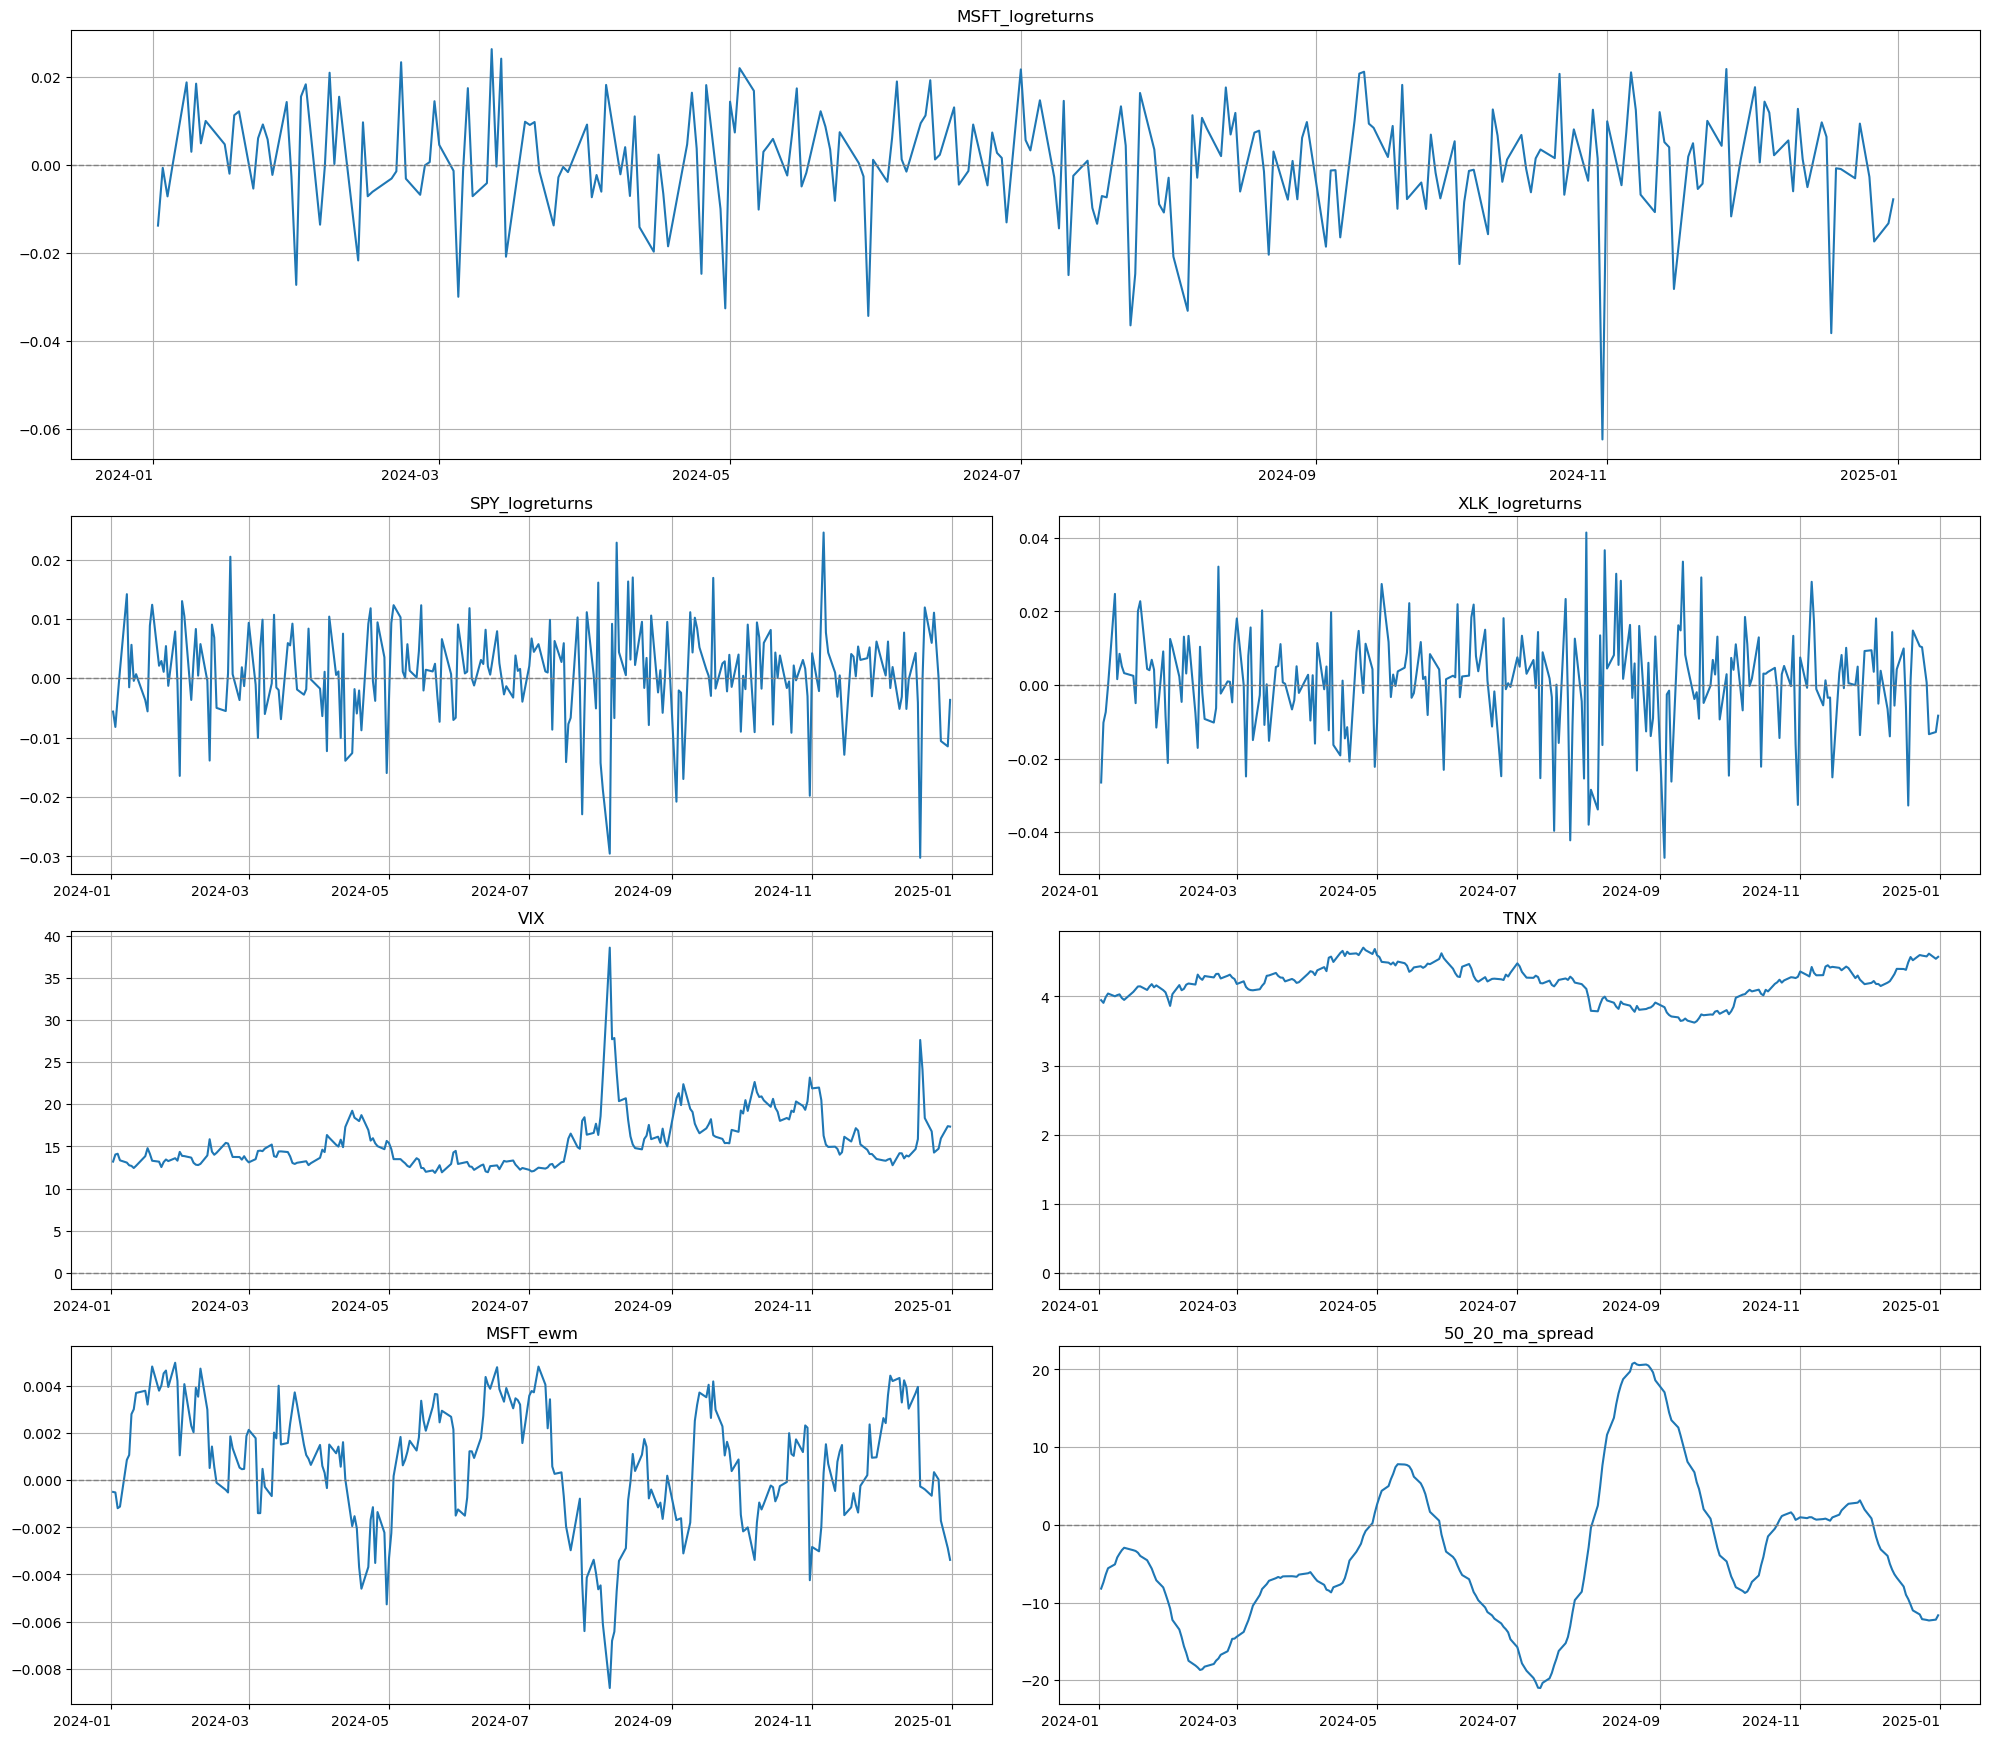

In [5]:
cols_to_plot = ['MSFT_logreturns', 'SPY_logreturns', 'XLK_logreturns', 'VIX', 'TNX','MSFT_ewm', '50_20_ma_spread']

fig = plt.figure(figsize=(20, 18))
gs = gridspec.GridSpec(4, 2, height_ratios=[1.2, 1, 1, 1])

ax0 = fig.add_subplot(gs[0, :])
df.loc['2024-01-01':, 'MSFT_logreturns'].plot(ax=ax0, title='MSFT_logreturns')
ax0.axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax0.grid(True)
ax0.set_xlabel("")
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax0.tick_params(axis='x', labelrotation=0)
other_cols = cols_to_plot[1:]
for i, col in enumerate(other_cols):
    row = (i // 2) + 1
    col_idx = i % 2
    ax = fig.add_subplot(gs[row, col_idx])
    df.loc['2024-01-01':, col].plot(ax=ax, title=col)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
    ax.grid(True)
    ax.set_xlabel("")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', labelrotation=0)
plt.tight_layout()
plt.subplots_adjust(bottom=0.05)
plt.savefig('media/univariate_viz')
plt.show()

Correlation between returns.

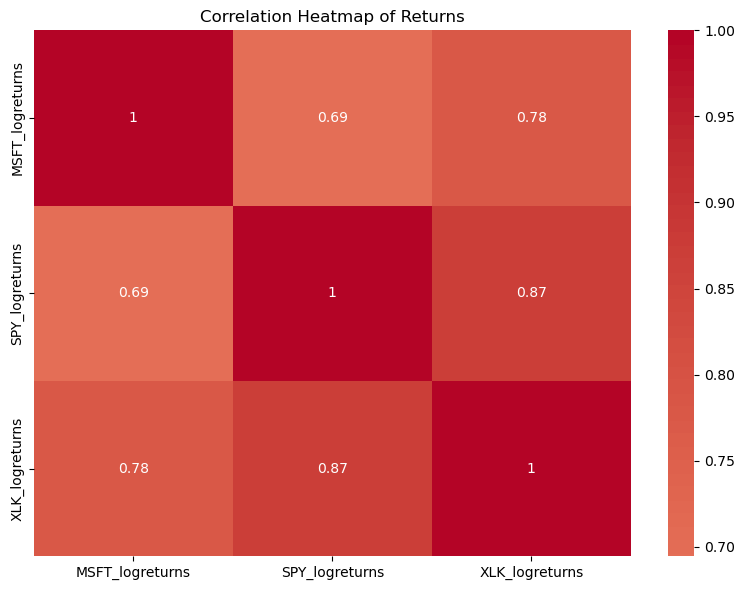

In [6]:
returns_cols = ['MSFT_logreturns', 'SPY_logreturns', 'XLK_logreturns']
corr_matrix = df[returns_cols].corr() # Compute correlation matrix

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Returns")
plt.tight_layout()
plt.savefig('media/correlation_heatmap')
plt.show()

**Correlation Insight**

There exists a **high degree of correlation** among the tickers **MSFT**, **SPY**, and **XLK**, which is both expected and economically intuitive:

- **MSFT** is a large-cap technology stock and a major component of both the **S&P 500** and the **XLK** ETF (which tracks the technology sector). As such, it is naturally correlated with XLK.
- **SPY** is an ETF that mirrors approximately **1/10th of the S&P 500**. Since MSFT is one of the top-weighted constituents of the index, its returns closely track both SPY and the broader market.

This high correlation reflects the **systematic exposure of MSFT** to both sectoral and macroeconomic movements.


**Modeling Implication**

This observed multicollinearity can negatively impact models that assume feature independence or rely on stable coefficient estimation.

- **Linear models** such as **Ordinary Least Squares (OLS)** or **Logistic Regression** may perform poorly in this setting, as their coefficient estimates become unstable or hard to interpret.
- To mitigate this, we can apply **Principal Component Analysis (PCA)** to transform the correlated features into a smaller set of **uncorrelated principal components**, capturing the directions of greatest variance while eliminating redundancy.

This preprocessing step allows us to **retain predictive power** while making the feature set more compatible with linear modeling assumptions.

In [7]:
#====SPLIT DATA & SCALE====
split_dict = pipeline.split(df=df, train_proportion=0.90,scale=True)
X_tr_scaled = split_dict['X_tr_scaled']
X_ts_scaled = split_dict['X_ts_scaled']
y_tr = split_dict['y_tr']
y_ts = split_dict['y_ts']

In [8]:
pca = PCA()
X_train_pca = pca.fit_transform(X_tr_scaled)
X_test_pca = pca.transform(X_ts_scaled)

X_test_pca = pd.DataFrame(X_test_pca, columns=[f'PCA_{i}' for i in range(1, X_test_pca.shape[1] + 1)])
X_train_pca = pd.DataFrame(X_train_pca, columns=[f'PCA_{i}' for i in range(1, X_train_pca.shape[1] + 1)])

In [9]:
X_train_pca

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10
0,1.522401,1.617338,0.440362,-0.862783,1.354148,0.733210,-0.656412,0.387957,-0.007630,0.819385
1,-0.041417,1.667383,-0.596422,-0.447209,1.148148,1.086294,-0.246007,0.180057,-0.852305,0.066049
2,2.675911,1.436161,0.629441,-0.671651,1.088425,0.873251,-0.449297,0.384111,-0.307233,-0.419909
3,-1.087106,2.166153,-0.514314,-1.344838,1.908990,0.190712,-0.860341,0.080004,0.010987,-0.190151
4,1.012525,1.602545,-0.059093,-0.751691,1.227126,0.893200,-0.443867,0.380263,-0.445596,-0.157412
...,...,...,...,...,...,...,...,...,...,...
5838,0.307921,0.551551,2.487925,4.647631,1.807832,1.087151,-0.573621,-0.780756,-0.064751,0.052517
5839,1.311497,0.411594,2.810181,4.888161,1.741308,1.020573,-0.591186,-0.920573,-0.648651,0.088727
5840,2.417431,0.232722,3.039892,4.659587,2.081451,0.864649,-0.628792,-0.787980,-0.531843,0.172248
5841,-1.003432,0.576185,1.699235,4.297699,3.058264,0.588318,-0.845863,-0.670697,-0.286882,0.065496


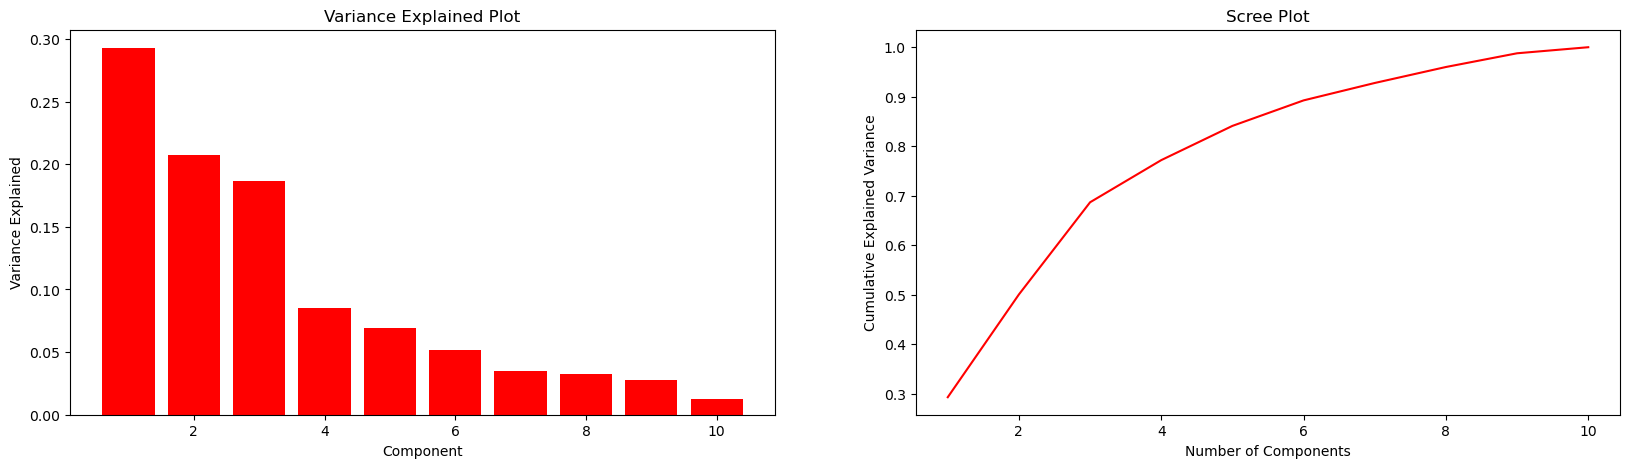

PC1 and PC2 explain 50.047% of the variance.


In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].bar(np.arange(1, X_train_pca.shape[1] + 1), pca.explained_variance_ratio_, color='red')
ax[0].set_xlabel('Component')
ax[0].set_ylabel('Variance Explained')
ax[0].set_title('Variance Explained Plot')

ax[1].plot(
    np.arange(1, len(pca.explained_variance_ratio_) + 1),
    np.cumsum(pca.explained_variance_ratio_),
    color='red'
)
ax[1].set_xlabel('Number of Components')
ax[1].set_ylabel('Cumulative Explained Variance')
ax[1].set_title('Scree Plot')

plt.savefig('media/pca_var_explained_and_screeplot.png')
plt.show()

print(f'PC1 and PC2 explain {np.sum(pca.explained_variance_ratio_[:2]) * 100:.3f}% of the variance.')

**PCA Visualization & Label Separation Insight**

After projecting the training data into the first two principal components and coloring by the target labels (buy = green, sell = red), we observe **substantial overlap between classes**. There is no clear visual separation in PCA space.

This result is expected and highlights a fundamental point:

- **PCA is an unsupervised technique** designed to capture directions of **maximum variance**, not necessarily the directions that best separate classes.
- In many real-world applications — especially in **financial data** — the signal-to-noise ratio is low. Price-based indicators and market-derived features often contain high variance driven by noise, macro shocks, or crowd behavior, not necessarily predictive structure.

This means that:
- **Poor class separation in PCA space doesn't imply useless features**, but rather that **PCA isn't optimized for classification**.
- If the problem of separating buy/sell signals were trivially solved by PCA, then anyone could generate alpha with a few matrix operations — and **markets would be instantly arbitraged**.

This reinforces the importance of:
- Trying **nonlinear dimensionality reduction techniques** like **UMAP** or **t-SNE**
- Using supervised learning models that directly optimize for classification accuracy
- Continuing to **engineer richer features** grounded in domain knowledge

